## imports

In [39]:
import sys
import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


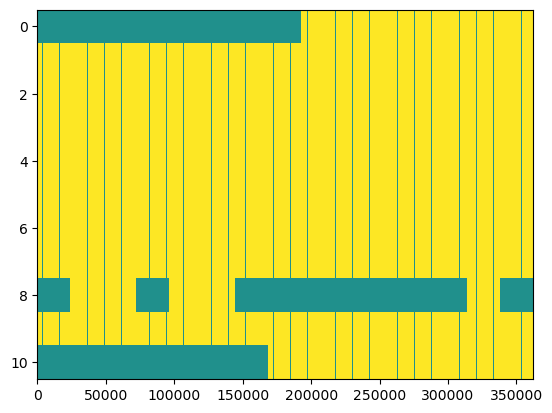

In [2]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## STA

(36, 10, 11)


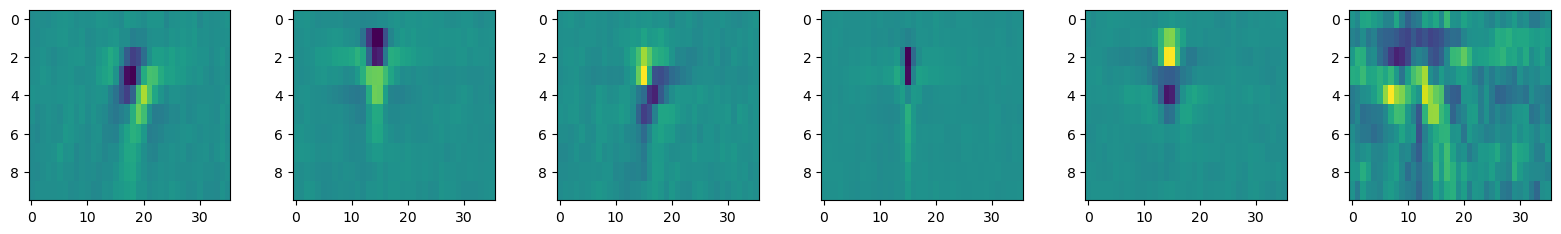

In [3]:
# Calculate STA 
Reff = data.robs * data.dfs
nspks = torch.sum(Reff, axis=0)
stas = (data.stim.T@data.robs / nspks).reshape([-1, num_lags, data.NC]).detach().numpy()
print(stas.shape)
# plot first 6
num_col = np.minimum(stas.shape[-1], 6)
ss(1, num_col)
for cc in range(num_col):
    plt.subplot(1, num_col, cc+1)
    imagesc(stas[:, :, cc])

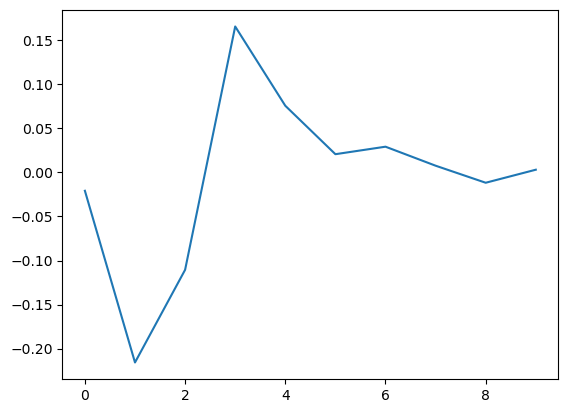

In [4]:
plt.plot(stas[13,:,1])
plt.show()

## GLMs

In [5]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    history_size=10,
    batch_size=4000,
    max_epochs=25,
    max_iter = 2000,
    device = device)

In [6]:
XTreg0 = 1.0
L1reg0 = 0.0001

glm_all_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=data.NC,
    bias=True, initialize_center = True,
    NLtype='softplus')
glm_all_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  } 

In [7]:
## Fit all GLMs at once -- example for choice of regularization above
glm_all = NDN.NDN( layer_list=[glm_all_par] )
glm_all.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
LLs = glm_all.eval_models(data[data.val_inds], null_adjusted=True)
print(LLs, np.mean(LLs))

[0.506696   0.52747655 0.99335647 0.2765969  0.4424274  0.02551436
 0.1550802  0.23138666 0.09804893 0.0625391  0.4010582 ] 0.33819824


In [8]:
## Optimize d2xt regularization
# compare losses for different regularization parameters
reglist = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
LLsR = np.zeros([len(reglist), data.NC])
data.set_cells()
for rr in range(len(reglist)):
    glm_all_par['reg_vals']['d2xt'] = reglist[rr]
    glm_iter = NDN.NDN( layer_list=[glm_all_par] )
    # fit the GLM with the current regularization parameter
    glm_iter.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
    LLsR[rr, :] = glm_iter.eval_models(data[data.val_inds], null_adjusted=True)
    print( "%7.2f  %9.7f  %9.7f"%(reglist[rr], np.mean(LLsR[rr,:]), LLsR[rr, 1]) )

  Reset cells_out to full dataset (11 cells).
   0.00  0.3577703  0.5388813
   0.00  0.3576496  0.5388784
   0.01  0.3581443  0.5388867
   0.03  0.3591650  0.5388957
   0.10  0.3602870  0.5387833
   0.30  0.3572565  0.5374881
   1.00  0.3382046  0.5274820
   3.00  0.2967035  0.4924659
  10.00  0.2285860  0.4091696
  30.00  0.1597380  0.3031245
 100.00  0.0918559  0.1798520
 300.00  0.0474783  0.0904125


In [9]:
LLsR.shape, len(reglist)

((12, 11), 12)

In [10]:
# get the maximum loss averaged over the regularization values 
LLs0 = np.max(np.mean(LLsR, axis=1))
LLs0

0.36028704859993677

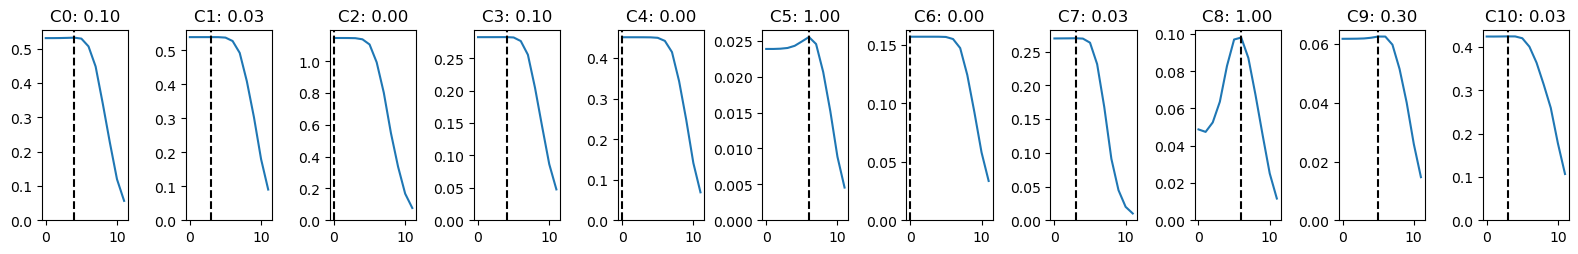

In [11]:
XTregs0 = np.zeros(data.NC)

num_col = np.minimum(data.NC, 11)
ss(1, num_col)
for cc in range(data.NC):
    b = np.argmax(LLsR[:, cc])
    XTregs0[cc] = reglist[b]

    # loss per cell
    if cc < num_col:
        plt.subplot(1, num_col, cc+1)
        plt.plot(LLsR[:, cc])
        ys = plt.ylim()
        plt.plot([b, b], [0, ys[1]], 'k--')
        plt.ylim([0, ys[1]])
        plt.title("C%d: %0.2f"%(cc, XTregs0[cc]))
plt.show()

## STA and GLM filters

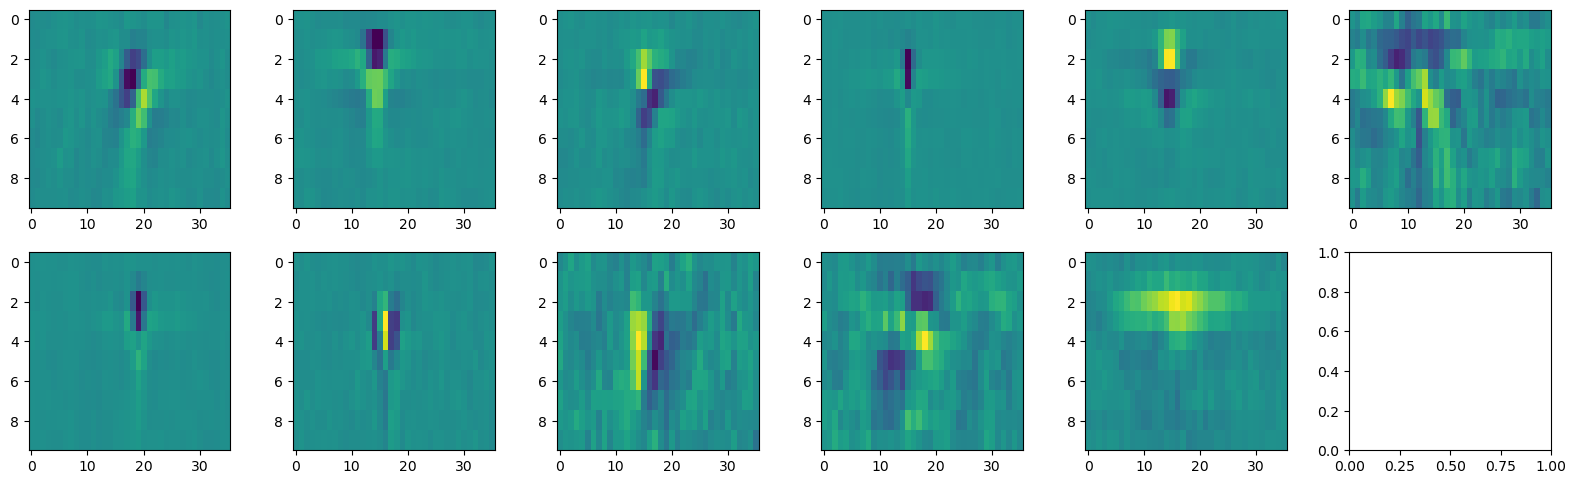

In [12]:
# plot STA filters
ss(2, 6)
for cc in range(11):
    plt.subplot(2, 6, cc+1)
    imagesc(stas[:, :, cc])

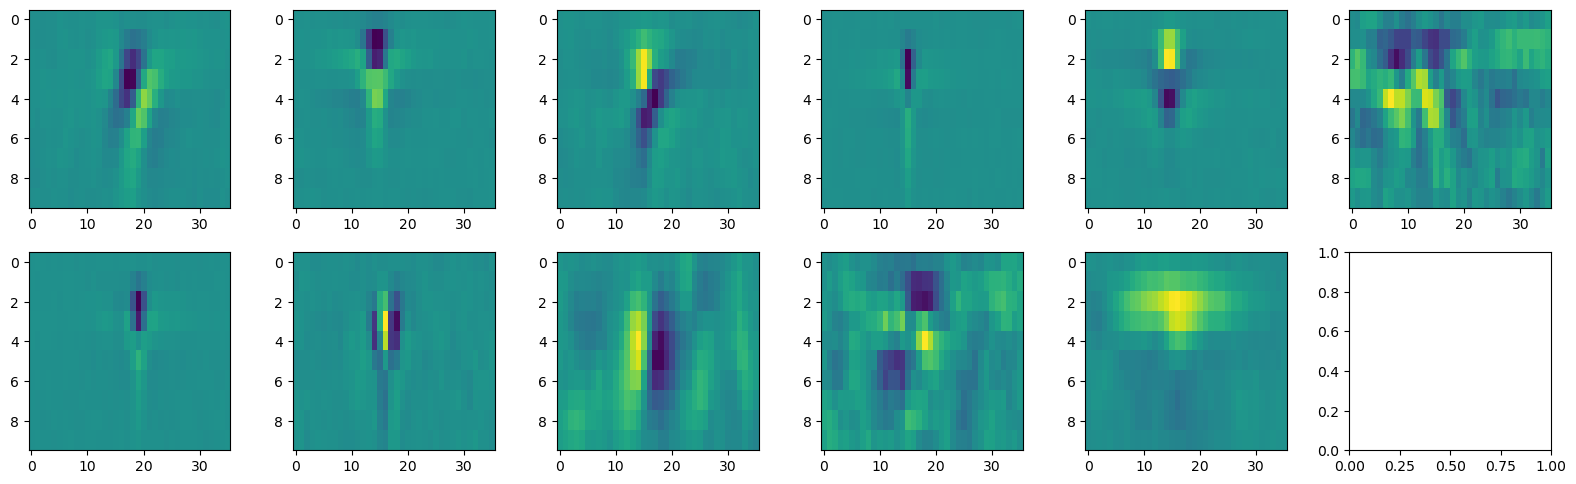

In [13]:
# plot GLM filters
ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    imagesc(glm_all.networks[0].layers[0].get_weights()[:,:,c])
plt.show()

## calc r2

In [23]:
glm_all.networks[0].layers[0](data.stim).shape, data.stim.shape

(torch.Size([362504, 11]), torch.Size([362504, 360]))

In [28]:
glm_all.networks[0].xstim_n

'stim'

In [32]:
# run the stim forward through the model
glm_all({'stim': data.stim})

tensor([[0.0346, 0.3557, 0.0477,  ..., 0.0418, 0.1039, 0.2344],
        [0.0482, 0.8815, 0.0143,  ..., 0.0331, 0.1679, 0.1623],
        [0.0598, 0.3015, 0.0038,  ..., 0.0272, 0.2501, 0.0916],
        ...,
        [0.4568, 0.1064, 0.1912,  ..., 0.0412, 0.2342, 0.0854],
        [0.1637, 0.5777, 0.4482,  ..., 0.0585, 0.1282, 0.1078],
        [0.0410, 0.2600, 0.1511,  ..., 0.0528, 0.0851, 0.1823]],
       grad_fn=<SoftplusBackward0>)

<Figure size 640x480 with 0 Axes>

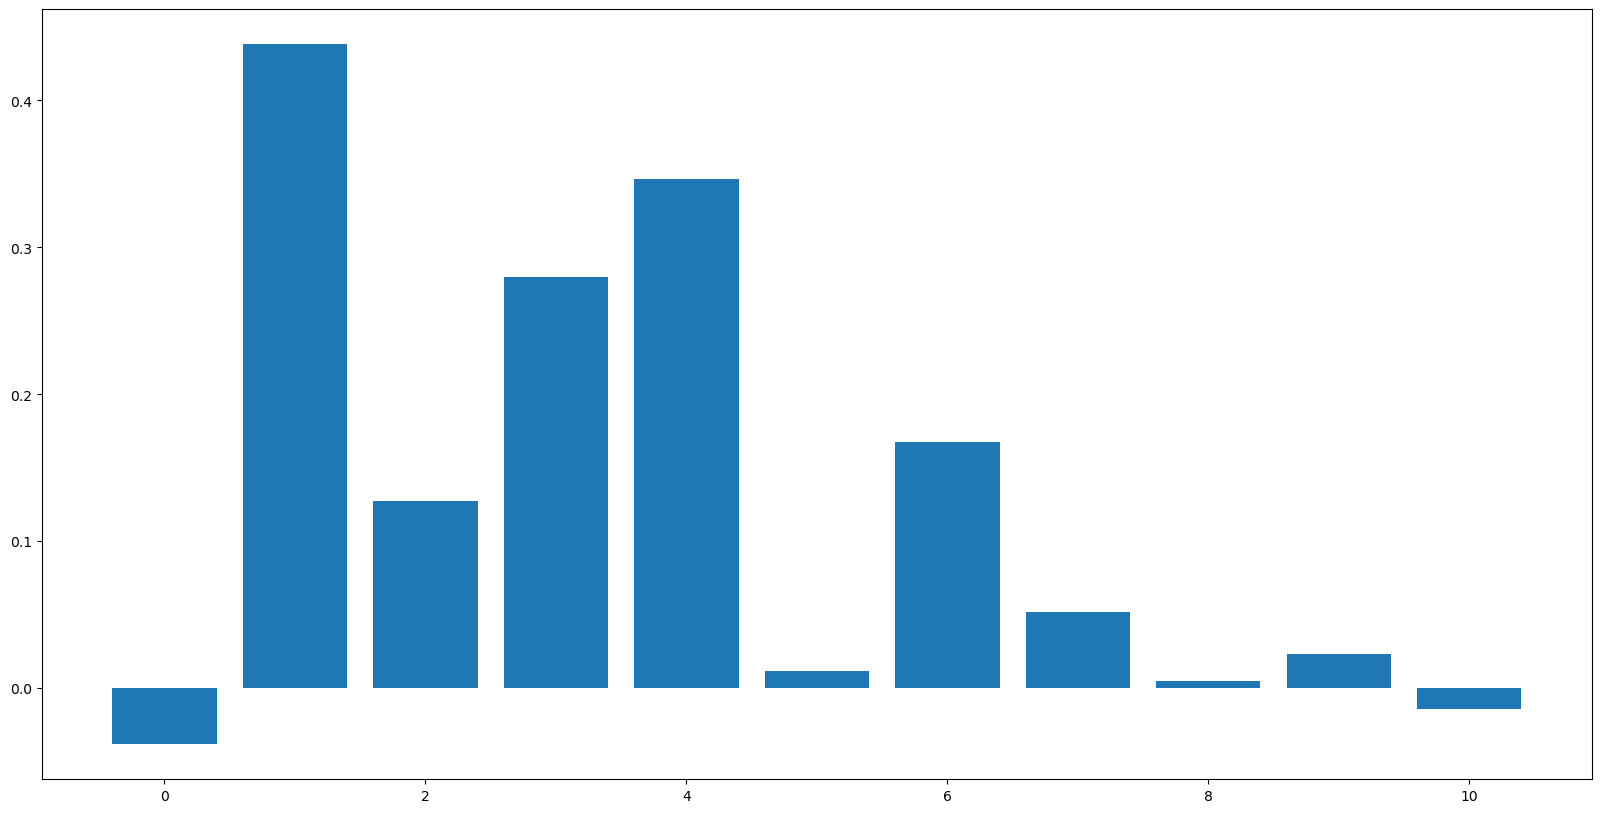

In [47]:
# R2
reload(met)
m.fig()
plt.bar(range(11), met.r2(data, glm_all))
plt.show()